In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import cvxpy as cp
import random
import time
import os
from joblib import Parallel, delayed

from src.model import Nonneg_dagma, MetMulDagma, BarrierDagma
import src.utils as utils

from baselines.colide import colide_ev
from baselines.dagma_linear import DAGMA_linear
from baselines.notears import notears_linear

SEED = 10
N_CPUS = os.cpu_count() // 2

np.random.seed(SEED)
random.seed(SEED)

/home/srey/Investigacion/cvx_dag_learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def run_exps(g, data_p, exps, thr=.2, verb=False):
    A_true, _, X = utils.simulate_sem(**data_p)
    A_true_bin = utils.to_bin(A_true, thr)
    X_std = utils.standarize(X)
    # X_norm = X/la.norm(X, axis=1, keepdims=True)

    M, N = X.shape

    fidelity = 1/data_p['n_samples']*la.norm(X - X @ A_true, 'fro')**2
    fidelity_norm = 1/data_p['n_samples']*la.norm(X_std - X_std @ A_true, 'fro')**2

    print(f'{g}: Fidelity: {fidelity:.3f}  -  Fidelity (norm): {fidelity_norm:.3f}')

    shd, fscore, err, acyc, runtime = [np.zeros(len(exps))  for _ in range(5)]
    for i, exp in enumerate(exps):
        # X_aux = X_norm if 'norm_x' in exp.keys() and exp['norm_x'] else X    
        X_aux = X_std if 'standarize' in exp.keys() and exp['standarize'] else X

        args = exp['args'].copy()
        if 'fix_lamb' in exp.keys() and not exp['fix_lamb']:
            args['lamb'] = get_lamb_value(N, M, args['lamb'])

        if exp['model'] == notears_linear:
            t_i = time.time()
            A_est = notears_linear(X_aux, **args)
            t_solved = time.time() - t_i
        else:
            model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
            t_i = time.time()
            model.fit(X_aux, **args)
            t_solved = time.time() - t_i

            A_est = model.W_est

        A_est_bin = utils.to_bin(A_est, thr)
        shd[i], _, _ = utils.count_accuracy(A_true_bin, A_est_bin)
        fscore[i] = f1_score(A_true_bin.flatten(), A_est_bin.flatten())
        err[i] = utils.compute_norm_sq_err(A_true, A_est)
        acyc[i] = model.dagness(A_est) if hasattr(model, 'dagness') else 1
        runtime[i] = t_solved

        if verb:
            print(f'\t-{exp["leg"]}: shd {shd[i]}  -  err: {err[i]:.3f}  -  time: {runtime[i]:.3f}')

    return shd, fscore, err, acyc, runtime

def get_lamb_value(n_nodes, n_samples, times=1):
    return np.sqrt(np.log(n_nodes) / n_samples) * times 

def compute_errsW(W_seq, W_true):
    errs = np.zeros(len(W_seq))
    norm_W_true = la.norm(W_true)
    for i, W_est in enumerate(W_seq):
        errs[i] = (la.norm(W_true - W_est)/norm_W_true)**2
    
    return errs
    
def plot_result(A_true, A_est, thr, plot_matrices=True):
    A_est_bin = utils.to_bin(A_est, thr)
    A_true_bin = utils.to_bin(A_true, thr)

    fro_err = utils.compute_norm_sq_err(A_true, A_est)
    fro_err_bin = utils.compute_norm_sq_err(A_true_bin, A_est_bin)
    sdh, _, _ = utils.count_accuracy(A_true_bin, A_est_bin)
    fscore = f1_score(A_true_bin.flatten(), A_est_bin.flatten())

    print(f'Err: {fro_err:.3f}  -  Err bin: {fro_err_bin:.3f}  -  shd: {sdh}  -  fscore: {fscore:.3f}')

    if plot_matrices:
        plt.figure(figsize=(8, 8))
        plt.subplot(2,2,1)
        plt.imshow(A_true)
        plt.colorbar()
        plt.title("A true")
        plt.subplot(2,2,2)
        plt.imshow(A_est)
        plt.colorbar()
        plt.title("A est")
        plt.subplot(2,2,3)
        plt.imshow(A_true_bin)
        plt.colorbar()
        plt.title("A true bin")
        plt.subplot(2,2,4)
        plt.imshow(A_est_bin)
        plt.colorbar()
        plt.title("A est bin")

def plot_convergence(model, W_true):

    errs_W = compute_errsW(model.seq_W, W_true)

    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1)
    plt.semilogy(model.diff)
    plt.title('Convergence of W')
    plt.subplot(1,3,2)
    plt.semilogy(errs_W)
    plt.title('Error')
    plt.subplot(1,3,3)
    plt.semilogy(model.acyclicity)
    plt.title('Acyclicity')
    plt.tight_layout()

## Quick comparisons

In [3]:
# DAG parameters
N = 100
g_type = 'er'
edges = N*4
edge_type = 'positive'  # Options: binary, positive, weighted
w_range = (.5, 1)  #(.3, .9)
norm_x = False
M = 500
variance = 1 # 1/np.sqrt(N)

A, dag, X = utils.simulate_sem(N, M, g_type, edges, permute=False, edge_type=edge_type,
                               w_range=w_range, noise_type='normal', var=variance)

if norm_x:
    X = X/la.norm(X, axis=1, keepdims=True)

print(X.shape)

print(f'Mean degree: {(A.sum(axis=0).mean()):2f}')
print('Mean norm of X:', la.norm(X, axis=1).mean())
print('Fidelity error:', 1/M*la.norm(X - X @ A, 'fro')**2)


(500, 100)
Mean degree: 2.837479
Mean norm of X: 130.7537940705763
Fidelity error: 99.89188115490819


### Proj Grad Descent DAGMA Alg

lamb: 1.9194103648752327e-05
Solved in 155.211455 seconds
Mean est value: 0.02967360483967919
Err: 0.087  -  Err bin: 0.076  -  shd: 29  -  fscore: 0.962


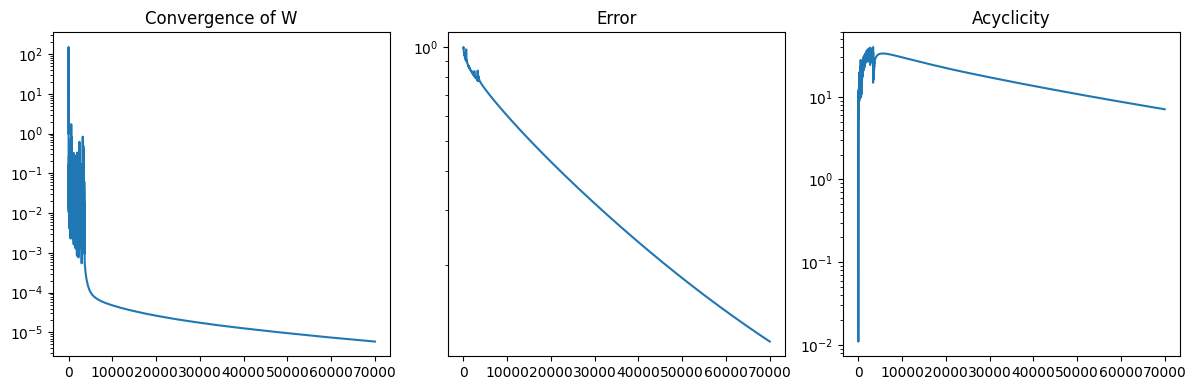

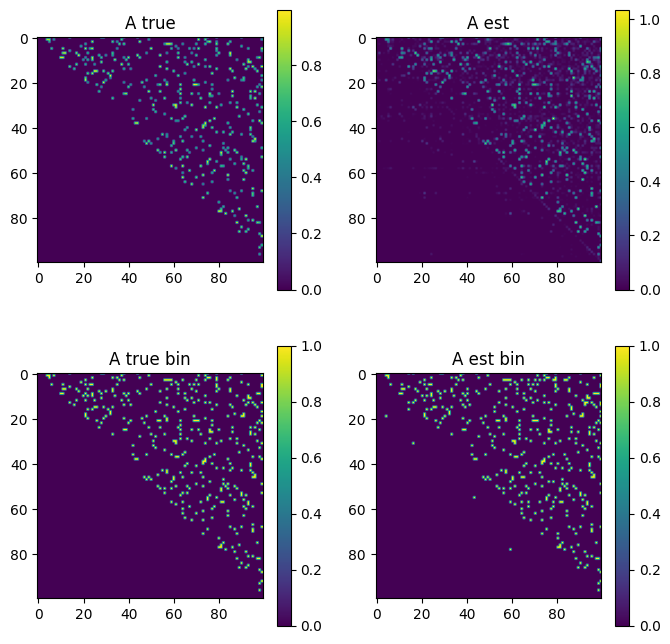

In [4]:
## Second set of hyperparams N = 50
lamb = get_lamb_value(N, M, 5e-2)
# if edges == 2*N:   
#     args = {'stepsize': 5e-2, 'alpha': .5, 's': 1, 'lamb': np.sqrt(np.log(N)/M)*2e-2, 'max_iters': 50000,
#             'tol': 1e-6,}
# else:
#     lamb = get_lamb_value(N, M, 2e-4)
#     args = {'stepsize': 1e-3, 'alpha': .5, 's': 1, 'lamb': np.sqrt(np.log(N)/M)*2e-2, 'max_iters': 10000,
#             'tol': 1e-6,}
# args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': np.sqrt(np.log(N)/M)*2e-2, 'max_iters': 50000,
#         'tol': 1e-6,}
lamb = get_lamb_value(N, M, 2e-4)
args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 70000,
        'tol': 1e-6,}

print('lamb:', args['lamb'])

t_i = time.time()
model_ppgd = Nonneg_dagma()
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_dagma2.mean())
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

Accelerated: Solved in 27.874491 seconds
Mean est value: 0.033353863399242414
Err: 0.026  -  Err bin: 0.010  -  shd: 4  -  fscore: 0.995


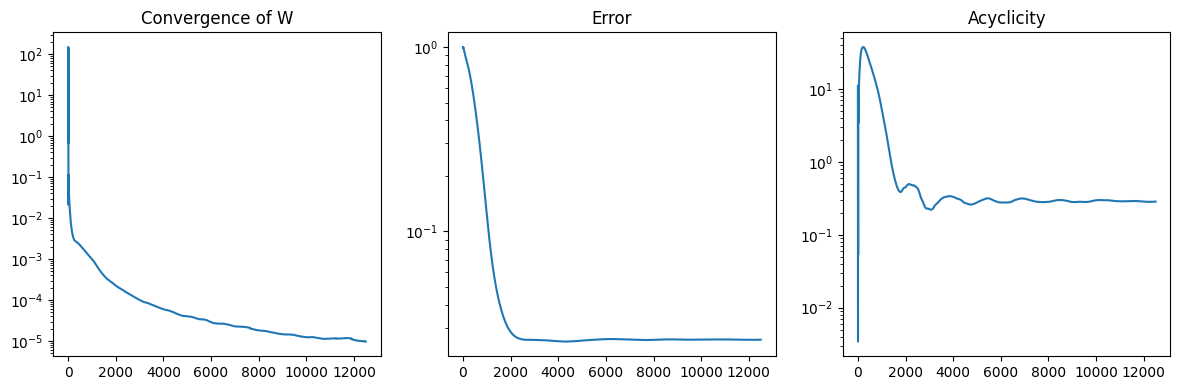

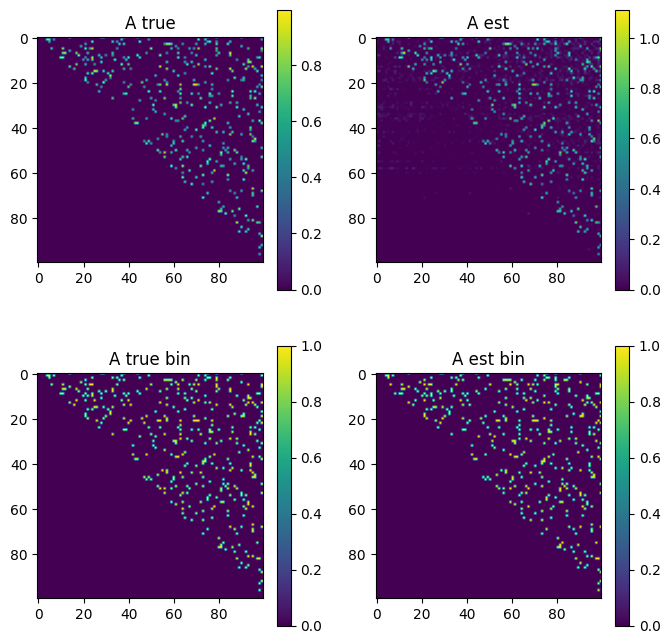

In [5]:
lamb = get_lamb_value(N, M, 2e-4)
args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 20000,
        'tol': 1e-5, 'opt_type': 'fista'}

t_i = time.time()
model_ppgd = Nonneg_dagma()
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Accelerated: Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_dagma2.mean())
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

Adam: Solved in 31.908576 seconds
Mean est value: 0.03335056222551282
Err: 0.026  -  Err bin: 0.010  -  shd: 4  -  fscore: 0.995


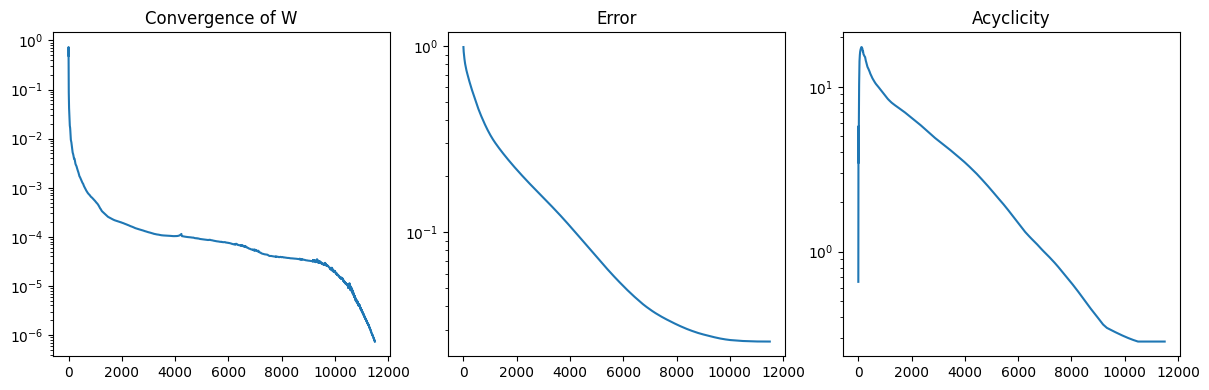

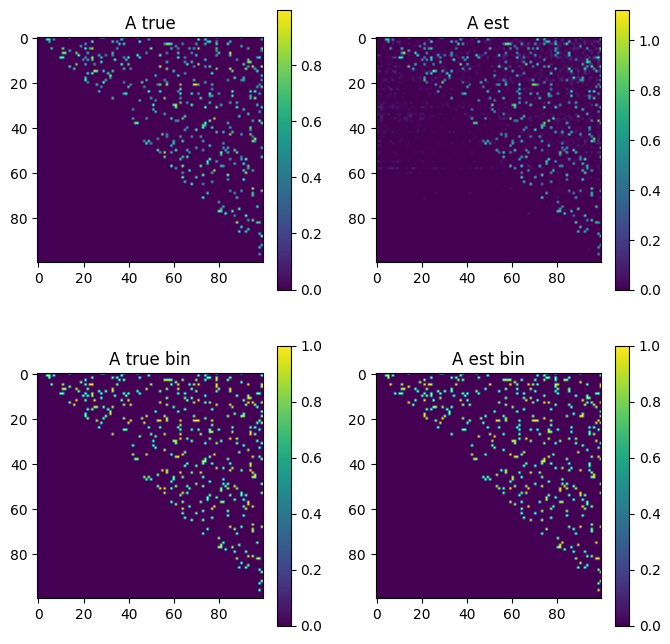

In [6]:
lamb = get_lamb_value(N, M, 2e-4)
args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 20000,
        'tol': 1e-6, 'opt_type': 'adam'}

t_i = time.time()
model_ppgd = Nonneg_dagma()
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Adam: Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_dagma2.mean())
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

### Method of Multipliers DAGMA Alg

lamb: 0.009597051824376163
Negative acyclicity. Projecting and reducing stepsize to:  0.00015
- 1/10. Diff: 0.000010 | Acycl: 10.148873 | Rho: 0.100 - Alpha: 1.025 - Step: 0.0001
- 2/10. Diff: 0.000004 | Acycl: 0.173933 | Rho: 0.100 - Alpha: 1.042 - Step: 0.0001
- 3/10. Diff: 0.000001 | Acycl: 0.045749 | Rho: 0.200 - Alpha: 1.051 - Step: 0.0001
- 4/10. Diff: 0.000001 | Acycl: 0.040967 | Rho: 0.400 - Alpha: 1.068 - Step: 0.0001
- 5/10. Diff: 0.000001 | Acycl: 0.003510 | Rho: 0.400 - Alpha: 1.069 - Step: 0.0001
- 6/10. Diff: 0.000001 | Acycl: 0.003510 | Rho: 0.800 - Alpha: 1.072 - Step: 0.0001
- 7/10. Diff: 0.000001 | Acycl: 0.003510 | Rho: 1.600 - Alpha: 1.078 - Step: 0.0001
- 8/10. Diff: 0.000001 | Acycl: 0.003510 | Rho: 3.200 - Alpha: 1.089 - Step: 0.0001
- 9/10. Diff: 0.000001 | Acycl: 0.003510 | Rho: 6.400 - Alpha: 1.111 - Step: 0.0001
- 10/10. Diff: 0.000001 | Acycl: 0.003492 | Rho: 12.800 - Alpha: 1.156 - Step: 0.0001
Solved in 340.098005 seconds
Mean est value: 0.0293415995563885

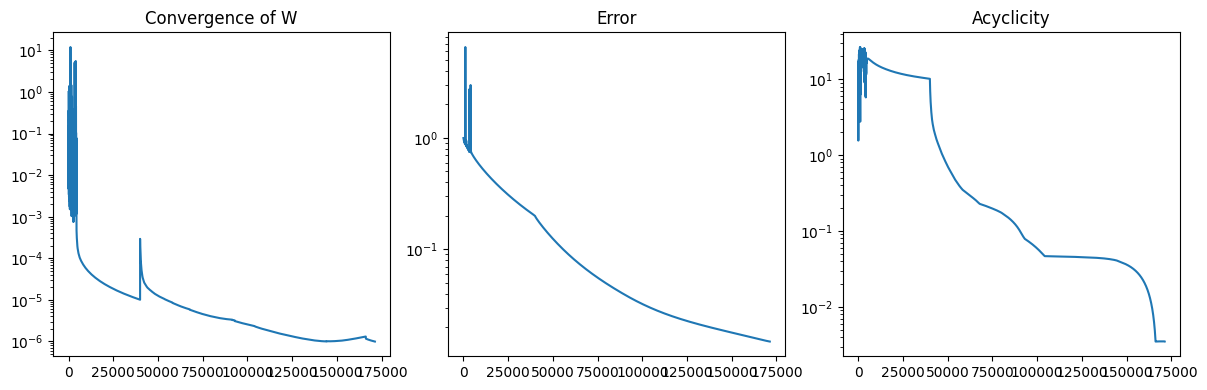

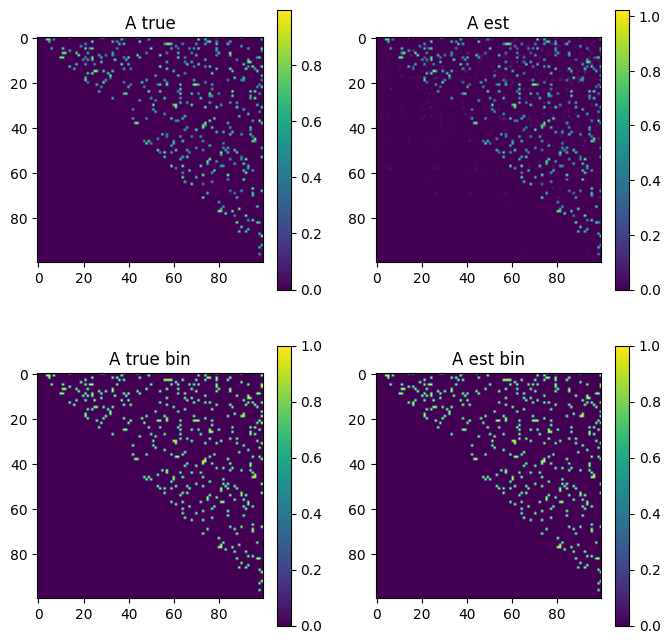

In [7]:
## Second set of hyperparams N = 50
lamb = get_lamb_value(N, M, 2e-2)
# 2N LINKS
# if edges == 2*N:
#     args = {'stepsize': 5e-2, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 5000,
#             'iters_out': 10, 'tol': 1e-6, 'beta': 5, 'dec_step': False, 'verb': True}
#         # args = {'stepsize': 1e-2, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 5000,
#         #     'iters_out': 10, 'tol': 1e-6, 'beta': 5, 'dec_step': False, 'verb': True}
# else:
# # 4N LINKS
#     lamb = get_lamb_value(N, M, 2e-2)
#     args = {'stepsize': 1e-3, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 30000,
#             'iters_out': 10, 'tol': 1e-6, 'beta': 5, 'dec_step': False, 'verb': True}

# lamb = get_lamb_value(N, M, 5e-3)
lamb = get_lamb_value(N, M, 1e-1)
args = {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 40000,
            'iters_out': 10, 'tol': 1e-6, 'beta': 2, 'verb': True}

print('lamb:', lamb)

t_i = time.time()
model = MetMulDagma()
A_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_est.mean())
plot_convergence(model, A)
plot_result(A, A_est, thr)

lamb: 0.009597051824376163
- 1/10. Diff: 0.000010 | Acycl: 8.331328 | Rho: 0.100 - Alpha: 0.843 - Step: 0.0001
Negative acyclicity. Projecting and reducing stepsize to:  5e-05
Negative acyclicity. Projecting and reducing stepsize to:  2.5e-05
Negative acyclicity. Projecting and reducing stepsize to:  1.25e-05
- 2/10. Diff: 0.000060 | Acycl: 0.007046 | Rho: 0.100 - Alpha: 0.844 - Step: 0.0000
- 3/10. Diff: 0.000000 | Acycl: 0.007046 | Rho: 0.200 - Alpha: 0.845 - Step: 0.0000
- 4/10. Diff: 0.000000 | Acycl: 0.007046 | Rho: 0.400 - Alpha: 0.848 - Step: 0.0000
- 5/10. Diff: 0.000000 | Acycl: 0.007046 | Rho: 0.800 - Alpha: 0.854 - Step: 0.0000
- 6/10. Diff: 0.000000 | Acycl: 0.007046 | Rho: 1.600 - Alpha: 0.865 - Step: 0.0000
- 7/10. Diff: 0.000000 | Acycl: 0.007046 | Rho: 3.200 - Alpha: 0.888 - Step: 0.0000
- 8/10. Diff: 0.000000 | Acycl: 0.007046 | Rho: 6.400 - Alpha: 0.933 - Step: 0.0000
- 9/10. Diff: 0.000000 | Acycl: 0.007046 | Rho: 12.800 - Alpha: 1.023 - Step: 0.0000
- 10/10. Diff: 0

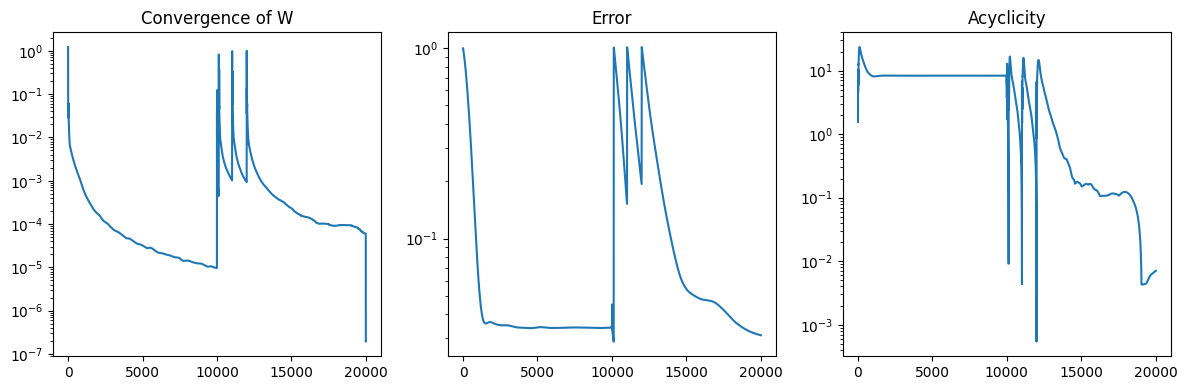

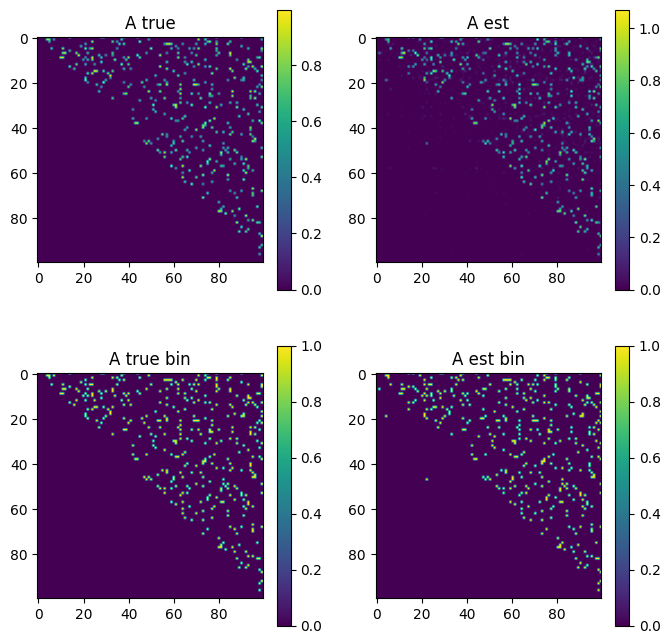

In [8]:
## Second set of hyperparams N = 50
lamb = get_lamb_value(N, M, 1e-1)

args = {'stepsize': 1e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 10000,
            'iters_out': 10, 'tol': 1e-6, 'beta': 2, 'dec_step': None, 'opt_type': 'fista', 'verb': True}

print('lamb:', lamb)

t_i = time.time()
model = MetMulDagma()
A_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_est.mean())
plot_convergence(model, A)
plot_result(A, A_est, thr)

lamb: 0.009597051824376163
- 1/10. Diff: 0.000084 | Acycl: 8.909780 | Rho: 0.100 - Alpha: 0.901 - Step: 0.0003
- 2/10. Diff: 0.000001 | Acycl: 0.003334 | Rho: 0.100 - Alpha: 0.901 - Step: 0.0003
- 3/10. Diff: 0.000000 | Acycl: 0.003333 | Rho: 0.200 - Alpha: 0.902 - Step: 0.0003
- 4/10. Diff: 0.000000 | Acycl: 0.003329 | Rho: 0.400 - Alpha: 0.903 - Step: 0.0003
- 5/10. Diff: 0.000000 | Acycl: 0.003321 | Rho: 0.800 - Alpha: 0.906 - Step: 0.0003
- 6/10. Diff: 0.000001 | Acycl: 0.003305 | Rho: 1.600 - Alpha: 0.911 - Step: 0.0003
- 7/10. Diff: 0.000000 | Acycl: 0.003272 | Rho: 3.200 - Alpha: 0.922 - Step: 0.0003
- 8/10. Diff: 0.000001 | Acycl: 0.003205 | Rho: 6.400 - Alpha: 0.942 - Step: 0.0003
- 9/10. Diff: 0.000001 | Acycl: 0.003044 | Rho: 12.800 - Alpha: 0.981 - Step: 0.0003
- 10/10. Diff: 0.000001 | Acycl: 0.002543 | Rho: 25.600 - Alpha: 1.046 - Step: 0.0003
Solved in 33.864590 seconds
Mean est value: 0.029352899734658648
Err: 0.010  -  Err bin: 0.000  -  shd: 0  -  fscore: 1.000


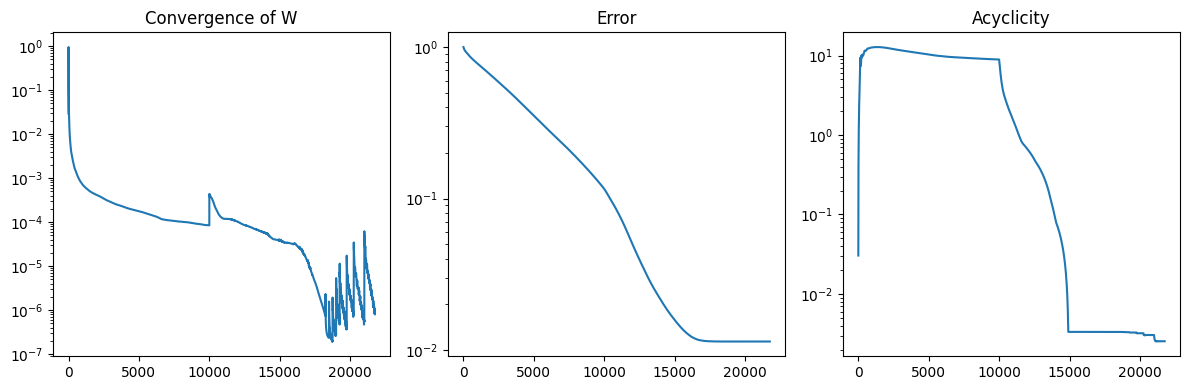

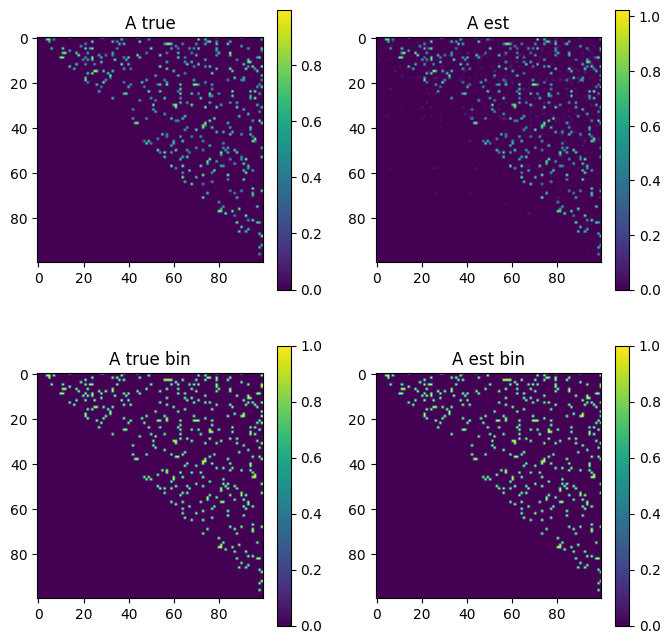

In [9]:
## Second set of hyperparams N = 50
lamb = get_lamb_value(N, M, 1e-1)
args = {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 10000,
            'iters_out': 10, 'tol': 1e-6, 'beta': 2, 'opt_type': 'adam', 'verb': True}

# args = {'stepsize': 1e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 3000,
#             'iters_out': 15, 'tol': 1e-6, 'beta': 2, 'opt_type': 'adam', 'verb': True}

print('lamb:', lamb)

t_i = time.time()
model = MetMulDagma()
A_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_est.mean())
plot_convergence(model, A)
plot_result(A, A_est, thr)

### Logarithmic barrier DAGMA Alg

In [10]:
# ## Second set of hyperparams N = 50

# lamb = get_lamb_value(N, M, 2e-2)
# print('lamb:', lamb)
# if norm_x:
#     lamb = get_lamb_value(N, M, 2e-4)
#     args = {'stepsize': 5e-1, 'alpha': 5e-3, 's': 1, 'lamb': lamb, 'iters_in': 5000,
#             'iters_out': 10, 'tol': 1e-6, 'beta': .5, 'verb': True}
# else:
#     lamb = get_lamb_value(N, M, 2e-2)
#     args = {'stepsize': 2e-2, 'alpha': .01, 's': 1, 'lamb': lamb, 'iters_in': 100,
#             'iters_out': 100, 'tol': 1e-6, 'beta': .9, 'verb': True}


# t_i = time.time()
# model = BarrierDagma()
# A_est = model.fit(X, **args, track_seq=True)
# t_solved = time.time() - t_i
# print(f'Solved in {t_solved:3f} seconds')

# # Plot description
# thr = .2
# plot_convergence(model, A)
# plot_result(A, A_est, thr)

## Comparing models - Unit variance - 4N Edges

In [11]:
Exps = [
    # Proj Grad Desc
    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': .1, 'max_iters': 20000,
     'opt_type': 'fista', 'tol': 1e-5}, 'fix_lamb': False, 'standarize': False, 'leg': 'PGD-FISTA'},

    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': .1, 'max_iters': 20000,
     'opt_type': 'adam', 'tol': 1e-5}, 'fix_lamb': False, 'standarize': False, 'leg': 'PGD-Adam'},

    # Method of Multipliers
    {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .1,
     'iters_in': 40000, 'iters_out': 10, 'beta': 2}, 'standarize': False, 'fix_lamb': False,
     'leg': 'MM'},

    {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .1,
     'iters_in': 10000, 'iters_out': 10, 'beta': 2, 'opt_type': 'fista'}, 'standarize': False, 'fix_lamb': False,
     'leg': 'MM-FISTA'},

    {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .1,
     'iters_in': 10000, 'iters_out': 10, 'beta': 2, 'opt_type': 'adam'}, 'standarize': False, 'fix_lamb': False,
     'leg': 'MM-adam'},

     {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .05,
     'iters_in': 5000, 'iters_out': 10, 'beta': 2, 'opt_type': 'adam'}, 'standarize': False, 'fix_lamb': True,
     'leg': 'MM-adam-fix'},
            

    # Colide
    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'leg': 'CoLiDe'},

    # DAGMA
    {'model': DAGMA_linear, 'init': {'loss_type': 'l2'}, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .8],
     'warm_iter': 2e4, 'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'leg': 'DAGMA'},

    # NoTears
    {'model': notears_linear, 'args': {'loss_type': 'l2', 'lambda1': .1, 'max_iter': 100}, 'standarize': False, 'leg': 'NoTears'},
]

In [12]:
N = 100

n_dags = 30
verb=True
data_params = {
    'n_nodes': N,
    'n_samples': 500, # 1000,
    'graph_type': 'er',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1
}

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=verb) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time:.3f} seconds -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32
26: Fidelity: 100.350  -  Fidelity (norm): 360.430
25: Fidelity: 99.762  -  Fidelity (norm): 266.280
16: Fidelity: 99.354  -  Fidelity (norm): 338.878
10: Fidelity: 99.507  -  Fidelity (norm): 357.485
11: Fidelity: 99.970  -  Fidelity (norm): 251.609
24: Fidelity: 99.867  -  Fidelity (norm): 335.004
14: Fidelity: 98.683  -  Fidelity (norm): 384.531
18: Fidelity: 99.427  -  Fidelity (norm): 438.379
5: Fidelity: 99.511  -  Fidelity (norm): 459.561
4: Fidelity: 98.891  -  Fidelity (norm): 384.318
7: Fidelity: 100.306  -  Fidelity (norm): 347.501
28: Fidelity: 102.664  -  Fidelity (norm): 378.917
19: Fidelity: 100.862  -  Fidelity (norm): 439.882
1: Fidelity: 99.975  -  Fidelity (norm): 372.822
0: Fidelity: 100.057  -  Fidelity (norm): 516.286
21: Fidelity: 100.559  -  Fidelity (norm): 371.004
22: Fidelity: 100.104  -  Fidelity (norm): 321.517
9: Fidelity: 99.791  -  Fidelity (norm): 279.769
23: Fidelity: 100.332  -  Fidelity (norm): 376.308
17: Fidelity: 99.653  -  Fidel

  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM-FISTA: shd 56.0  -  err: 0.080  -  time: 27.074
	-MM: shd 0.0  -  err: 0.013  -  time: 102.653
	-MM-adam-fix: shd 1.0  -  err: 0.013  -  time: 15.490


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM-adam: shd 0.0  -  err: 0.010  -  time: 20.456
	-MM-FISTA: shd 6.0  -  err: 0.018  -  time: 20.712


  0%|          | 0/130000.0 [00:33<?, ?it/s]


	-CoLiDe: shd 11.0  -  err: 0.033  -  time: 33.558
	-MM: shd 10.0  -  err: 0.030  -  time: 128.824
	-MM-adam-fix: shd 3.0  -  err: 0.015  -  time: 25.125


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM: shd 0.0  -  err: 0.018  -  time: 147.261


  0%|          | 0/130000.0 [00:45<?, ?it/s]


	-CoLiDe: shd 28.0  -  err: 0.083  -  time: 45.621
	-MM-FISTA: shd 0.0  -  err: 0.009  -  time: 24.397
	-MM-adam: shd 0.0  -  err: 0.010  -  time: 34.492
	-MM-FISTA: shd 1.0  -  err: 0.013  -  time: 18.926
	-MM: shd 4.0  -  err: 0.024  -  time: 156.483
	-DAGMA: shd 11.0  -  err: 0.034  -  time: 39.906
	-MM: shd 2.0  -  err: 0.018  -  time: 166.101
	-MM-adam-fix: shd 1.0  -  err: 0.017  -  time: 27.266


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM: shd 14.0  -  err: 0.039  -  time: 177.969
	-MM: shd 1.0  -  err: 0.024  -  time: 183.297
	-MM-adam: shd 0.0  -  err: 0.011  -  time: 25.255


  0%|          | 0/130000.0 [00:53<?, ?it/s]


	-CoLiDe: shd 10.0  -  err: 0.032  -  time: 53.045
	-MM-FISTA: shd 2.0  -  err: 0.012  -  time: 22.862
	-DAGMA: shd 36.0  -  err: 0.098  -  time: 44.162
	-MM-adam: shd 0.0  -  err: 0.009  -  time: 44.448
	-MM: shd 1.0  -  err: 0.019  -  time: 194.396
	-MM: shd 19.0  -  err: 0.062  -  time: 209.395
	-MM-FISTA: shd 136.0  -  err: 0.193  -  time: 48.170
	-MM-adam-fix: shd 0.0  -  err: 0.011  -  time: 25.486


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM-FISTA: shd 17.0  -  err: 0.032  -  time: 31.670
	-MM-adam-fix: shd 5.0  -  err: 0.017  -  time: 25.805


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM-adam: shd 0.0  -  err: 0.009  -  time: 30.455
	-MM: shd 15.0  -  err: 0.053  -  time: 226.396
	-MM: shd 9.0  -  err: 0.025  -  time: 224.654
	-MM-FISTA: shd 110.0  -  err: 0.174  -  time: 47.158
	-DAGMA: shd 5.0  -  err: 0.027  -  time: 39.560


  0%|          | 0/130000.0 [00:54<?, ?it/s]


	-CoLiDe: shd 27.0  -  err: 0.055  -  time: 54.714
	-MM: shd 17.0  -  err: 0.059  -  time: 236.468
	-MM-adam: shd 0.0  -  err: 0.011  -  time: 27.367
	-MM: shd 23.0  -  err: 0.056  -  time: 237.517
	-MM-FISTA: shd 1.0  -  err: 0.013  -  time: 18.668
	-MM: shd 14.0  -  err: 0.043  -  time: 239.738
	-MM: shd 8.0  -  err: 0.036  -  time: 236.138
	-MM-FISTA: shd 0.0  -  err: 0.010  -  time: 19.260
	-MM-adam-fix: shd 6.0  -  err: 0.016  -  time: 25.074


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM-adam: shd 0.0  -  err: 0.010  -  time: 38.701
	-MM-adam: shd 0.0  -  err: 0.010  -  time: 25.687
	-MM-FISTA: shd 0.0  -  err: 0.010  -  time: 11.714


  0%|          | 0/130000.0 [00:46<?, ?it/s]


	-CoLiDe: shd 35.0  -  err: 0.085  -  time: 47.006
	-MM-FISTA: shd 267.0  -  err: 0.518  -  time: 51.819
	-MM-FISTA: shd 341.0  -  err: 0.794  -  time: 62.589
	-MM-FISTA: shd 0.0  -  err: 0.009  -  time: 18.662
	-MM-adam-fix: shd 6.0  -  err: 0.024  -  time: 19.408


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM-FISTA: shd 14.0  -  err: 0.025  -  time: 19.737
	-DAGMA: shd 23.0  -  err: 0.054  -  time: 32.413
	-MM-adam-fix: shd 0.0  -  err: 0.015  -  time: 23.056


  0%|          | 0/130000.0 [00:50<?, ?it/s]


	-CoLiDe: shd 56.0  -  err: 0.130  -  time: 50.232
	-MM-adam-fix: shd 4.0  -  err: 0.022  -  time: 19.995


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM-adam: shd 0.0  -  err: 0.010  -  time: 30.053
	-MM-adam: shd 0.0  -  err: 0.011  -  time: 34.541
	-MM-adam: shd 0.0  -  err: 0.010  -  time: 20.510
	-MM-adam: shd 0.0  -  err: 0.010  -  time: 24.804
	-DAGMA: shd 32.0  -  err: 0.078  -  time: 27.919
	-MM-adam: shd 0.0  -  err: 0.010  -  time: 31.997
	-MM-FISTA: shd 295.0  -  err: 0.593  -  time: 46.145


  0%|          | 0/130000.0 [00:49<?, ?it/s]


	-CoLiDe: shd 29.0  -  err: 0.076  -  time: 49.730
	-MM-adam: shd 0.0  -  err: 0.010  -  time: 33.747
	-MM-adam: shd 0.0  -  err: 0.009  -  time: 37.897
	-MM-adam-fix: shd 0.0  -  err: 0.015  -  time: 22.200
	-MM-adam-fix: shd 0.0  -  err: 0.014  -  time: 23.810


  0%|          | 0/130000.0 [00:31<?, ?it/s]


	-CoLiDe: shd 12.0  -  err: 0.043  -  time: 31.808


  0%|          | 0/130000.0 [00:46<?, ?it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-CoLiDe: shd 16.0  -  err: 0.051  -  time: 46.803
	-MM-adam-fix: shd 2.0  -  err: 0.014  -  time: 31.608
	-MM-adam-fix: shd 1.0  -  err: 0.018  -  time: 27.836


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-DAGMA: shd 57.0  -  err: 0.130  -  time: 38.674
	-MM-adam-fix: shd 4.0  -  err: 0.023  -  time: 22.316


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM: shd 27.0  -  err: 0.076  -  time: 308.008


  0%|          | 0/130000.0 [00:45<?, ?it/s]


	-CoLiDe: shd 48.0  -  err: 0.099  -  time: 45.342
	-MM-adam-fix: shd 5.0  -  err: 0.018  -  time: 23.932


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM-adam-fix: shd 0.0  -  err: 0.013  -  time: 26.772


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM-adam: shd 0.0  -  err: 0.011  -  time: 34.389


  0%|          | 0/130000.0 [00:30<?, ?it/s]


	-CoLiDe: shd 13.0  -  err: 0.043  -  time: 30.115
	-MM: shd 99.0  -  err: 0.202  -  time: 324.245
	-MM: shd 49.0  -  err: 0.125  -  time: 328.005
	-MM: shd 51.0  -  err: 0.127  -  time: 328.124
	-DAGMA: shd 12.0  -  err: 0.046  -  time: 29.374
	-MM-FISTA: shd 0.0  -  err: 0.010  -  time: 24.994
	-DAGMA: shd 28.0  -  err: 0.081  -  time: 43.426
	-MM: shd 28.0  -  err: 0.082  -  time: 337.062
	-MM-FISTA: shd 0.0  -  err: 0.010  -  time: 13.544
	-MM-adam-fix: shd 2.0  -  err: 0.015  -  time: 25.764


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-DAGMA: shd 34.0  -  err: 0.078  -  time: 38.226
	-DAGMA: shd 16.0  -  err: 0.053  -  time: 45.853
	-MM-FISTA: shd 0.0  -  err: 0.010  -  time: 20.557


  0%|          | 0/130000.0 [00:46<?, ?it/s]


	-CoLiDe: shd 51.0  -  err: 0.120  -  time: 46.799


  0%|          | 0/130000.0 [00:49<?, ?it/s]


	-CoLiDe: shd 25.0  -  err: 0.073  -  time: 49.962


  0%|          | 0/130000.0 [00:58<?, ?it/s]


	-CoLiDe: shd 44.0  -  err: 0.123  -  time: 58.381


  0%|          | 0/130000.0 [00:49<?, ?it/s]


	-CoLiDe: shd 53.0  -  err: 0.129  -  time: 49.216
	-MM: shd 102.0  -  err: 0.236  -  time: 357.194
	-MM-FISTA: shd 23.0  -  err: 0.047  -  time: 32.665
	-DAGMA: shd 11.0  -  err: 0.045  -  time: 37.074
	-MM: shd 254.0  -  err: 0.534  -  time: 369.000
	-MM-FISTA: shd 0.0  -  err: 0.010  -  time: 30.736
	-MM: shd 82.0  -  err: 0.164  -  time: 372.313


  0%|          | 0/130000.0 [00:56<?, ?it/s]


	-CoLiDe: shd 50.0  -  err: 0.102  -  time: 56.130
	-MM: shd 79.0  -  err: 0.146  -  time: 371.321
	-MM-adam: shd 0.0  -  err: 0.010  -  time: 41.387


  0%|          | 0/130000.0 [01:00<?, ?it/s]


	-CoLiDe: shd 22.0  -  err: 0.060  -  time: 60.103
	-MM: shd 92.0  -  err: 0.198  -  time: 380.430
	-MM-adam: shd 0.0  -  err: 0.010  -  time: 43.823
	-MM-FISTA: shd 0.0  -  err: 0.011  -  time: 21.340
	-MM-FISTA: shd 68.0  -  err: 0.105  -  time: 29.510
	-MM-adam: shd 4.0  -  err: 0.017  -  time: 39.815
	-DAGMA: shd 17.0  -  err: 0.060  -  time: 36.924
	-DAGMA: shd 41.0  -  err: 0.101  -  time: 41.298
	-MM-FISTA: shd 0.0  -  err: 0.011  -  time: 21.965
	-MM-FISTA: shd 3.0  -  err: 0.018  -  time: 29.094


  0%|          | 0/130000.0 [00:51<?, ?it/s]


	-CoLiDe: shd 20.0  -  err: 0.058  -  time: 51.141
	-MM-adam: shd 1.0  -  err: 0.010  -  time: 37.207
	-DAGMA: shd 53.0  -  err: 0.129  -  time: 44.920
	-MM-adam-fix: shd 1.0  -  err: 0.019  -  time: 26.766


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-DAGMA: shd 13.0  -  err: 0.058  -  time: 49.159
	-MM-FISTA: shd 1.0  -  err: 0.011  -  time: 21.498
	-MM-adam: shd 0.0  -  err: 0.010  -  time: 46.528
	-DAGMA: shd 37.0  -  err: 0.103  -  time: 48.094
	-MM: shd 202.0  -  err: 0.543  -  time: 421.660
	-MM-adam-fix: shd 1.0  -  err: 0.015  -  time: 34.453


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-DAGMA: shd 19.0  -  err: 0.054  -  time: 41.772
	-MM-adam-fix: shd 2.0  -  err: 0.017  -  time: 34.367


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM: shd 237.0  -  err: 0.507  -  time: 419.726
	-MM-adam: shd 0.0  -  err: 0.009  -  time: 37.222
	-MM-adam: shd 0.0  -  err: 0.011  -  time: 38.854
	-MM-adam-fix: shd 5.0  -  err: 0.029  -  time: 32.809


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM-adam: shd 1.0  -  err: 0.011  -  time: 36.474
	-MM-adam: shd 0.0  -  err: 0.011  -  time: 49.882
	-MM-adam: shd 0.0  -  err: 0.010  -  time: 52.826
	-MM-FISTA: shd 1.0  -  err: 0.012  -  time: 22.155
	-MM-adam-fix: shd 1.0  -  err: 0.016  -  time: 40.261


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-DAGMA: shd 12.0  -  err: 0.047  -  time: 59.319
	-MM-adam-fix: shd 2.0  -  err: 0.016  -  time: 29.324


  0%|          | 0/130000.0 [01:08<?, ?it/s]


	-CoLiDe: shd 39.0  -  err: 0.101  -  time: 68.053
	-MM-FISTA: shd 106.0  -  err: 0.165  -  time: 49.803
	-MM-adam-fix: shd 0.0  -  err: 0.014  -  time: 46.070


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM-adam-fix: shd 1.0  -  err: 0.019  -  time: 31.503


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM-adam: shd 1.0  -  err: 0.011  -  time: 47.627
	-MM-adam-fix: shd 2.0  -  err: 0.020  -  time: 48.714


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM-adam-fix: shd 1.0  -  err: 0.018  -  time: 53.957


  0%|          | 0/130000.0 [01:16<?, ?it/s]


	-CoLiDe: shd 26.0  -  err: 0.075  -  time: 76.147


  0%|          | 0/130000.0 [01:16<?, ?it/s]


	-CoLiDe: shd 32.0  -  err: 0.072  -  time: 76.577
	-NoTears: shd 24.0  -  err: 0.082  -  time: 355.057


  0%|          | 0/130000.0 [01:34<?, ?it/s]


	-CoLiDe: shd 24.0  -  err: 0.066  -  time: 94.366
	-DAGMA: shd 36.0  -  err: 0.105  -  time: 50.325
	-MM-adam: shd 0.0  -  err: 0.009  -  time: 56.964


  0%|          | 0/130000.0 [01:17<?, ?it/s]


	-CoLiDe: shd 32.0  -  err: 0.071  -  time: 77.925


  0%|          | 0/130000.0 [01:32<?, ?it/s]
  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-MM-adam-fix: shd 8.0  -  err: 0.028  -  time: 51.719
	-CoLiDe: shd 61.0  -  err: 0.149  -  time: 92.979
	-DAGMA: shd 27.0  -  err: 0.075  -  time: 50.643


  0%|          | 0/130000.0 [01:24<?, ?it/s]


	-CoLiDe: shd 41.0  -  err: 0.092  -  time: 84.782
	-DAGMA: shd 23.0  -  err: 0.059  -  time: 53.312


  0%|          | 0/130000.0 [01:35<?, ?it/s]


	-CoLiDe: shd 17.0  -  err: 0.046  -  time: 95.441
	-MM-adam-fix: shd 0.0  -  err: 0.016  -  time: 41.317


  0%|          | 0/130000.0 [00:00<?, ?it/s]

	-DAGMA: shd 22.0  -  err: 0.064  -  time: 56.512
	-DAGMA: shd 24.0  -  err: 0.062  -  time: 55.352


  0%|          | 0/130000.0 [01:37<?, ?it/s]


	-CoLiDe: shd 31.0  -  err: 0.070  -  time: 97.499
	-NoTears: shd 21.0  -  err: 0.067  -  time: 381.974
	-DAGMA: shd 55.0  -  err: 0.119  -  time: 49.701


  0%|          | 0/130000.0 [01:53<?, ?it/s]


	-CoLiDe: shd 44.0  -  err: 0.088  -  time: 113.347
	-DAGMA: shd 14.0  -  err: 0.043  -  time: 56.028
	-DAGMA: shd 36.0  -  err: 0.094  -  time: 78.480


  0%|          | 0/130000.0 [01:25<?, ?it/s]


	-CoLiDe: shd 30.0  -  err: 0.088  -  time: 85.016
	-DAGMA: shd 42.0  -  err: 0.102  -  time: 47.084
	-DAGMA: shd 44.0  -  err: 0.093  -  time: 80.279


  0%|          | 0/130000.0 [02:41<?, ?it/s]


	-CoLiDe: shd 44.0  -  err: 0.097  -  time: 161.493
	-DAGMA: shd 28.0  -  err: 0.091  -  time: 72.034
	-DAGMA: shd 70.0  -  err: 0.134  -  time: 122.318
	-NoTears: shd 31.0  -  err: 0.085  -  time: 553.880
	-NoTears: shd 55.0  -  err: 0.141  -  time: 698.109
	-NoTears: shd 28.0  -  err: 0.082  -  time: 660.270
	-NoTears: shd 24.0  -  err: 0.067  -  time: 789.013
	-NoTears: shd 23.0  -  err: 0.071  -  time: 707.888
	-NoTears: shd 77.0  -  err: 0.180  -  time: 775.003
	-NoTears: shd 37.0  -  err: 0.093  -  time: 677.460
	-NoTears: shd 41.0  -  err: 0.081  -  time: 846.150
	-NoTears: shd 47.0  -  err: 0.137  -  time: 1080.165
	-NoTears: shd 57.0  -  err: 0.152  -  time: 891.720
	-NoTears: shd 70.0  -  err: 0.159  -  time: 778.274
	-NoTears: shd 51.0  -  err: 0.134  -  time: 1069.880
	-NoTears: shd 63.0  -  err: 0.176  -  time: 954.576
	-NoTears: shd 69.0  -  err: 0.174  -  time: 840.213
	-NoTears: shd 87.0  -  err: 0.229  -  time: 1072.547
	-NoTears: shd 75.0  -  err: 0.190  -  time: 1065

In [13]:
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='median')

,leg,shd,fscore,err,acyc,time
0,PGD-FISTA,44.4667 ± 113.7663,0.9300 ± 0.1799,0.1456 ± 0.3455,1.4809 ± 0.4419,9.5156 ± 2.7243
1,PGD-Adam,0.1667 ± 0.5821,0.9997 ± 0.0013,0.0125 ± 0.0012,1.6319 ± 0.2605,12.5988 ± 3.4132
2,MM,47.9667 ± 68.9630,0.9396 ± 0.0842,0.1166 ± 0.1506,0.0075 ± 0.0238,246.0834 ± 106.3629
3,MM-FISTA,48.6000 ± 92.1041,0.9361 ± 0.1270,0.0987 ± 0.1895,0.0764 ± 0.2068,27.7045 ± 13.0354
4,MM-adam,0.2333 ± 0.7608,0.9996 ± 0.0014,0.0103 ± 0.0014,0.0020 ± 0.0007,35.2052 ± 10.1880
5,MM-adam-fix,2.1333 ± 2.1868,0.9967 ± 0.0038,0.0174 ± 0.0043,0.0121 ± 0.0035,29.8664 ± 10.0082
6,CoLiDe,32.3667 ± 14.1197,0.9489 ± 0.0201,0.0803 ± 0.0296,0.0003 ± 0.0000,66.1110 ± 27.7100
7,DAGMA,29.2667 ± 15.6481,0.9535 ± 0.0220,0.0773 ± 0.0293,1.0000 ± 0.0000,50.3380 ± 18.2213
8,NoTears,57.1000 ± 23.0570,0.9152 ± 0.0316,0.1466 ± 0.0538,1.0000 ± 0.0000,886.4303 ± 213.3939


,leg,shd,fscore,err,acyc,time
0,PGD-FISTA,0.0000 ± 113.7663,1.0000 ± 0.1799,0.0125 ± 0.3455,1.5558 ± 0.4419,9.3453 ± 2.7243
1,PGD-Adam,0.0000 ± 0.5821,1.0000 ± 0.0013,0.0123 ± 0.0012,1.6349 ± 0.2605,14.6472 ± 3.4132
2,MM,16.0000 ± 68.9630,0.9743 ± 0.0842,0.0548 ± 0.1506,0.0015 ± 0.0238,236.3029 ± 106.3629
3,MM-FISTA,1.5000 ± 92.1041,0.9969 ± 0.1270,0.0127 ± 0.1895,0.0041 ± 0.2068,22.5085 ± 13.0354
4,MM-adam,0.0000 ± 0.7608,1.0000 ± 0.0014,0.0100 ± 0.0014,0.0019 ± 0.0007,35.5078 ± 10.1880
5,MM-adam-fix,1.0000 ± 2.1868,0.9982 ± 0.0038,0.0161 ± 0.0043,0.0126 ± 0.0035,26.7692 ± 10.0082
6,CoLiDe,30.5000 ± 14.1197,0.9523 ± 0.0201,0.0755 ± 0.0296,0.0003 ± 0.0000,55.4217 ± 27.7100
7,DAGMA,27.5000 ± 15.6481,0.9538 ± 0.0220,0.0765 ± 0.0293,1.0000 ± 0.0000,46.4685 ± 18.2213
8,NoTears,58.5000 ± 23.0570,0.9104 ± 0.0316,0.1504 ± 0.0538,1.0000 ± 0.0000,953.6134 ± 213.3939


## Comparing methods - 2N Edges

In [14]:
Exps = [
    # Proj Grad Desc
    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': .1, 'max_iters': 20000,
     'opt_type': 'fista', 'tol': 1e-5}, 'fix_lamb': False, 'standarize': False, 'leg': 'PGD-FISTA'},

    {'model': Nonneg_dagma, 'args': {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': .1, 'max_iters': 20000,
     'opt_type': 'adam', 'tol': 1e-5}, 'fix_lamb': False, 'standarize': False, 'leg': 'PGD-Adam'},

    # Method of Multipliers
    {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .1,
     'iters_in': 40000, 'iters_out': 10, 'beta': 2}, 'standarize': False, 'fix_lamb': False,
     'leg': 'MM'},

    {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .1,
     'iters_in': 10000, 'iters_out': 10, 'beta': 2, 'opt_type': 'fista'}, 'standarize': False, 'fix_lamb': False,
     'leg': 'MM-FISTA'},

    {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .1,
     'iters_in': 10000, 'iters_out': 10, 'beta': 2, 'opt_type': 'adam'}, 'standarize': False, 'fix_lamb': False,
     'leg': 'MM-adam'},

     {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .05,
     'iters_in': 5000, 'iters_out': 10, 'beta': 2, 'opt_type': 'adam'}, 'standarize': False, 'fix_lamb': True,
     'leg': 'MM-adam-fix'},
            

    # Colide
    {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
     'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'leg': 'CoLiDe'},

    # DAGMA
    {'model': DAGMA_linear, 'init': {'loss_type': 'l2'}, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .8],
     'warm_iter': 2e4, 'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'leg': 'DAGMA'},

    # NoTears
    {'model': notears_linear, 'args': {'loss_type': 'l2', 'lambda1': .1, 'max_iter': 100}, 'standarize': False, 'leg': 'NoTears'},
]

### 100 nodes and 2N edges

In [15]:
###  1000 samples - 100 nodes  #####
N = 100

n_dags = 25
data_params = {
    'n_nodes': N,
    'n_samples': 500, # 1000,
    'graph_type': 'er',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (.5, 1),
    'var': 1,
}

print('CPUs employed:', N_CPUS)

t_init = time.time()
results = Parallel(n_jobs=N_CPUS)(delayed(run_exps)(g, data_params, Exps, thr=.2, verb=False) for g in range(n_dags))
ellapsed_time = time.time() - t_init
print(f'----- Solved in {ellapsed_time/60:.3} minutes -----')

# Extract results
shd, fscore, err, acyc, runtime = zip(*results)
metrics = {'shd': shd, 'fscore': fscore, 'err': err, 'acyc': acyc, 'time': runtime}


CPUs employed: 32
0: Fidelity: 99.166  -  Fidelity (norm): 83.547
1: Fidelity: 99.166  -  Fidelity (norm): 74.474
2: Fidelity: 99.166  -  Fidelity (norm): 86.251
3: Fidelity: 99.166  -  Fidelity (norm): 79.338
4: Fidelity: 99.166  -  Fidelity (norm): 94.518
5: Fidelity: 99.166  -  Fidelity (norm): 74.226
6: Fidelity: 99.166  -  Fidelity (norm): 82.351
7: Fidelity: 99.166  -  Fidelity (norm): 85.536
8: Fidelity: 99.166  -  Fidelity (norm): 85.159
10: Fidelity: 99.166  -  Fidelity (norm): 86.291
9: Fidelity: 99.166  -  Fidelity (norm): 78.503
11: Fidelity: 99.166  -  Fidelity (norm): 78.843
24: Fidelity: 100.084  -  Fidelity (norm): 83.375
21: Fidelity: 100.867  -  Fidelity (norm): 74.127
23: Fidelity: 100.550  -  Fidelity (norm): 97.654
19: Fidelity: 100.058  -  Fidelity (norm): 71.361
18: Fidelity: 100.548  -  Fidelity (norm): 98.949
16: Fidelity: 99.614  -  Fidelity (norm): 83.142
13: Fidelity: 100.605  -  Fidelity (norm): 73.057
12: Fidelity: 100.169  -  Fidelity (norm): 86.856
14: F

  0%|          | 0/130000.0 [00:18<?, ?it/s]
  0%|          | 0/130000.0 [00:18<?, ?it/s]
  0%|          | 0/130000.0 [00:21<?, ?it/s]
  0%|          | 0/130000.0 [00:20<?, ?it/s]
  0%|          | 0/130000.0 [00:28<?, ?it/s]
  0%|          | 0/130000.0 [00:34<?, ?it/s]
  0%|          | 0/130000.0 [00:30<?, ?it/s]
  0%|          | 0/130000.0 [00:33<?, ?it/s]
  0%|          | 0/130000.0 [00:32<?, ?it/s]
  0%|          | 0/130000.0 [00:32<?, ?it/s]
  0%|          | 0/130000.0 [00:34<?, ?it/s]
  0%|          | 0/130000.0 [00:37<?, ?it/s]
  0%|          | 0/130000.0 [00:34<?, ?it/s]
  0%|          | 0/130000.0 [00:34<?, ?it/s]
  0%|          | 0/130000.0 [00:37<?, ?it/s]
  0%|          | 0/130000.0 [00:39<?, ?it/s]
  0%|          | 0/130000.0 [00:31<?, ?it/s]
  0%|          | 0/130000.0 [00:35<?, ?it/s]
  0%|          | 0/130000.0 [00:42<?, ?it/s]
  0%|          | 0/130000.0 [00:43<?, ?it/s]
  0%|          | 0/130000.0 [00:35<?, ?it/s]
  0%|          | 0/130000.0 [00:41<?, ?it/s]
  0%|     

----- Solved in 4.87e+02 seconds -----


In [16]:
# M = 1000
exps_leg = [exp['leg'] for exp in Exps]
utils.display_results(exps_leg, metrics, agg='mean')
utils.display_results(exps_leg, metrics, agg='median')

,leg,shd,fscore,err,acyc,time
0,PGD-FISTA,0.1600 ± 0.4630,0.9995 ± 0.0015,0.0210 ± 0.0084,0.7234 ± 0.3196,2.5151 ± 0.9965
1,PGD-Adam,0.3200 ± 0.6145,0.9986 ± 0.0027,0.0235 ± 0.0043,0.4926 ± 0.2934,2.5296 ± 0.7141
2,MM,0.2000 ± 0.5657,0.9992 ± 0.0023,0.0169 ± 0.0019,0.0072 ± 0.0009,72.5910 ± 10.2621
3,MM-FISTA,15.2000 ± 38.6937,0.9661 ± 0.0814,0.0685 ± 0.1323,0.0119 ± 0.0205,21.2054 ± 7.2162
4,MM-adam,0.7200 ± 2.0692,0.9975 ± 0.0062,0.0178 ± 0.0059,0.0052 ± 0.0007,17.7671 ± 3.9768
5,MM-adam-fix,2.1200 ± 2.8750,0.9914 ± 0.0085,0.0192 ± 0.0102,0.0084 ± 0.0012,15.1349 ± 3.2953
6,CoLiDe,6.1600 ± 4.2772,0.9783 ± 0.0133,0.0366 ± 0.0161,0.0001 ± 0.0000,33.4869 ± 7.2743
7,DAGMA,5.4400 ± 4.2622,0.9809 ± 0.0133,0.0348 ± 0.0160,1.0000 ± 0.0000,33.1552 ± 7.6967
8,NoTears,5.2000 ± 3.1241,0.9805 ± 0.0101,0.0330 ± 0.0149,1.0000 ± 0.0000,186.8967 ± 43.4586


,leg,shd,fscore,err,acyc,time
0,PGD-FISTA,0.0000 ± 0.4630,1.0000 ± 0.0015,0.0187 ± 0.0084,0.7474 ± 0.3196,2.0837 ± 0.9965
1,PGD-Adam,0.0000 ± 0.6145,1.0000 ± 0.0027,0.0233 ± 0.0043,0.5255 ± 0.2934,2.4221 ± 0.7141
2,MM,0.0000 ± 0.5657,1.0000 ± 0.0023,0.0166 ± 0.0019,0.0069 ± 0.0009,73.7634 ± 10.2621
3,MM-FISTA,0.0000 ± 38.6937,1.0000 ± 0.0814,0.0174 ± 0.1323,0.0062 ± 0.0205,19.5585 ± 7.2162
4,MM-adam,0.0000 ± 2.0692,1.0000 ± 0.0062,0.0161 ± 0.0059,0.0051 ± 0.0007,16.7323 ± 3.9768
5,MM-adam-fix,2.0000 ± 2.8750,0.9929 ± 0.0085,0.0147 ± 0.0102,0.0085 ± 0.0012,14.2340 ± 3.2953
6,CoLiDe,5.0000 ± 4.2772,0.9804 ± 0.0133,0.0356 ± 0.0161,0.0001 ± 0.0000,34.6268 ± 7.2743
7,DAGMA,4.0000 ± 4.2622,0.9839 ± 0.0133,0.0316 ± 0.0160,1.0000 ± 0.0000,33.5630 ± 7.6967
8,NoTears,5.0000 ± 3.1241,0.9822 ± 0.0101,0.0320 ± 0.0149,1.0000 ± 0.0000,185.9129 ± 43.4586


,leg,shd,fscore,err,acyc,time
0,PGD-FISTA,0.1600 ± 0.4630,0.9995 ± 0.0015,0.0210 ± 0.0084,0.7234 ± 0.3196,2.5151 ± 0.9965
1,PGD-Adam,0.3200 ± 0.6145,0.9986 ± 0.0027,0.0235 ± 0.0043,0.4926 ± 0.2934,2.5296 ± 0.7141
2,MM,0.2000 ± 0.5657,0.9992 ± 0.0023,0.0169 ± 0.0019,0.0072 ± 0.0009,72.5910 ± 10.2621
3,MM-FISTA,15.2000 ± 38.6937,0.9661 ± 0.0814,0.0685 ± 0.1323,0.0119 ± 0.0205,21.2054 ± 7.2162
4,MM-adam,0.7200 ± 2.0692,0.9975 ± 0.0062,0.0178 ± 0.0059,0.0052 ± 0.0007,17.7671 ± 3.9768
5,MM-adam-fix,2.1200 ± 2.8750,0.9914 ± 0.0085,0.0192 ± 0.0102,0.0084 ± 0.0012,15.1349 ± 3.2953
6,CoLiDe,6.1600 ± 4.2772,0.9783 ± 0.0133,0.0366 ± 0.0161,0.0001 ± 0.0000,33.4869 ± 7.2743
7,DAGMA,5.4400 ± 4.2622,0.9809 ± 0.0133,0.0348 ± 0.0160,1.0000 ± 0.0000,33.1552 ± 7.6967
8,NoTears,5.2000 ± 3.1241,0.9805 ± 0.0101,0.0330 ± 0.0149,1.0000 ± 0.0000,186.8967 ± 43.4586
